In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import glob

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
# data_dir = glob.glob('work_data/*/*.*')
data_dir = 'work_data'

In [3]:
batch_size = 32
img_height = 180
img_width = 180
num_classes = 3

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 714 files belonging to 3 classes.
Using 572 files for training.
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-06-12 15:58:32.940383: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-12 15:58:32.940522: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 714 files belonging to 3 classes.
Using 142 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['15830', '20114', '90130']


In [7]:
TOTUNE = tf.data.AUTOrain_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

NameError: name 'AUTOTUNE' is not defined

In [8]:
normalization_layer = layers.Rescaling(1./255)


In [9]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


2022-06-12 15:58:33.703784: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-12 15:58:33.704155: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


0.0 1.0


In [10]:
with tf.device("/device:CPU:0"):
  data_augmentation = keras.Sequential(
    [
      layers.RandomFlip("horizontal",
                        input_shape=(img_height,
                                    img_width,
                                    3)),
      layers.RandomRotation(0.1),
      layers.RandomZoom(0.1),
    ]
  )

In [11]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [13]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)       

In [14]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/20


2022-06-12 15:58:38.895959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 1.0219 - accuracy: 0.4948

2022-06-12 15:58:47.376446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 11s 371ms/step - loss: 1.0219 - accuracy: 0.4948 - val_loss: 0.7165 - val_accuracy: 0.6549
Epoch 2/20
 8/18 [============>.................] - ETA: 4s - loss: 0.5309 - accuracy: 0.6875

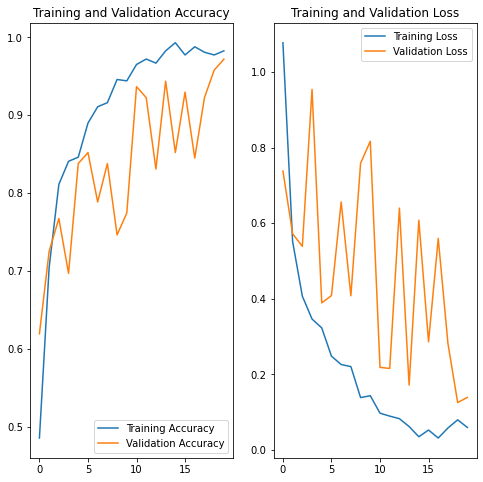

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
def predict_img(img_path):
    # img_url = "https://t1.daumcdn.net/cfile/blog/9924C23C5A51A68C2E"
    # img_path = tf.keras.utils.get_file('Red_sunflower', origin=img_url)
    img_path = img_path

    img = tf.keras.utils.load_img(
        img_path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    prediction = class_names[np.argmax(score)], 100 * np.max(score)

    print('-'*50)
    print('진짜로는 ', img_path)

    if 100 * np.max(score) < 50: 
        print('어ㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓ?????')
        print(np.max(score))
    elif prediction[0] == '90130':   
        prediction = '오징어 짬뽕'
        print("아마도 \"" + str(prediction) + "\"이지 않을까요???" + str(100 * np.max(score)))
    elif prediction[0] == '20114': 
        prediction = '불닭'
        print("아마도 \"" + str(prediction) + "\"이지 않을까요???" + str(100 * np.max(score)))
    elif prediction[0] == '15830': 
        prediction = '진짜장'
        print("아마도 \"" + str(prediction) + "\"이지 않을까요???" + str(100 * np.max(score)))



In [25]:
for i in glob.glob('val_img/*.*'): 
    predict_img(i)

--------------------------------------------------
진짜로는  val_img/oj01.jpeg
아마도 "오징어 짬뽕"이지 않을까요???99.12341237068176
--------------------------------------------------
진짜로는  val_img/bul02.jpeg
아마도 "불닭"이지 않을까요???99.99994039535522
--------------------------------------------------
진짜로는  val_img/jin01.jpeg
아마도 "진짜장"이지 않을까요???95.79455852508545
--------------------------------------------------
진짜로는  val_img/bul01.jpeg
아마도 "오징어 짬뽕"이지 않을까요???88.64965438842773
--------------------------------------------------
진짜로는  val_img/infer.jpeg
아마도 "오징어 짬뽕"이지 않을까요???99.77256655693054


In [23]:
def predict_img_live(img):
    img_array = tf.expand_dims(img, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    prediction = class_names[np.argmax(score)], 100 * np.max(score)

    print('-'*50)

    if 100 * np.max(score) < 90: 
        print('어ㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓ?????')
        print(np.max(score))
    elif prediction[0] == '90130':   
        prediction = '오징어 짬뽕'
        print("아마도 \"" + str(prediction) + "\"이지 않을까요???" + str(100 * np.max(score)))
    elif prediction[0] == '20114': 
        prediction = '불닭'
        print("아마도 \"" + str(prediction) + "\"이지 않을까요???" + str(100 * np.max(score)))
    elif prediction[0] == '15830': 
        prediction = '진짜장'
        print("아마도 \"" + str(prediction) + "\"이지 않을까요???" + str(100 * np.max(score)))



In [24]:
import numpy as np
import cv2
cap = cv2.VideoCapture(1)
if not cap.isOpened():
    print("Cannot open camera")
    exit()
while 1:
    # Capture frame-by-frame
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    
    # Our operations on the frame come here
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, dsize=(180,180), interpolation = cv2.INTER_AREA)
    predict_img_live(img)


2022-05-31 10:12:04.092699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


--------------------------------------------------
어ㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓ?????
0.6962297
--------------------------------------------------
어ㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓ?????
0.6125368
--------------------------------------------------
어ㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓ?????
0.60655373
--------------------------------------------------
어ㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓ?????
0.609347
--------------------------------------------------
어ㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓ?????
0.62787867
--------------------------------------------------
어ㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓ?????
0.61141795
--------------------------------------------------
어ㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓ?????
0.60108095
--------------------------------------------------
어ㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓ?????
0.61531335
--------------------------------------------------
어ㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓ?????
0.6083517
--------------------------------------------------
어ㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓ?????
0.6185924
--------------------------------------------------
어ㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓ?????
0.61409664
--------------------------------------------------
어ㅓㅓㅓㅓㅓㅓㅓㅓ

KeyboardInterrupt: 

In [19]:
tmp.shape


(720, 1280, 3)

In [20]:
img = tf.keras.utils.load_img(
    '/Users/tori/Desktop/aiffel_test/drone/val_img/bul01.jpeg', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)

img_array.shape

(180, 180, 3)